In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import chardet
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import heapq
import re
import plotnine
import copy
import pydot
import graphviz
import datetime
from graphviz import Source
from scipy.stats import randint as sp_randint
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from IPython.display import display
from pprint import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorboard.plugins.hparams import api as hp
#tf.enable_eager_execution()

In [2]:
# Importing processed data into notebook

sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm'
datapath = os.path.join(sourcepath, 'data','processed','IBM_HR_Data_Cleaned.csv')

IBMData = pd.read_csv(datapath)

In [3]:
# Dropping irrelevant variables

IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)

In [5]:
# Changing the types of some variables 

numvars = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 
          'PercentSalaryHike','PerformanceRating','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
          'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
newnumvars = ['Education','EnvironmentSatisfaction','JobInvolvement','JobLevel','JobSatisfaction','PerformanceRating',
              'RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']
catvars = [item for item in IBMData.columns.to_list() if item not in numvars and item not in newnumvars and item != 'Attrition']

In [6]:
IBMData[numvars] = IBMData[numvars].apply(pd.to_numeric, axis = 1, downcast = 'float')
IBMData[newnumvars] = IBMData[newnumvars].apply(pd.to_numeric, axis = 1, downcast = 'float')
IBMData[catvars] = IBMData[catvars].astype('category')

In [7]:
# Now rename some of the categorical variable levels

IBMData['BusinessTravel'].cat.rename_categories(
        {'Travel_Rarely':'Rare','Travel_Frequently':'Freq','Non-Travel':'No'}, inplace = True)
IBMData['Department'].cat.rename_categories(
    {'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
IBMData['EducationField'].cat.rename_categories(
    {'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'EducHR'}, inplace = True)
IBMData['JobRole'].cat.rename_categories(
    {'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'ManufDir','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'ResDir','Human Resources':'RoleHR'}, inplace = True)

In [8]:
# Now re-categorize the Attrition (outcome) variable from object to int

exit_status_map = {'Yes':1, 'No':0}
IBMData['Attrition'] = IBMData['Attrition'].map(exit_status_map)

In [9]:
# Now generate a new dataframe and then separate the predictors from outcome, and encode the dummies

IBMDataNew = IBMData.copy(deep = True)
IBMDataNewLabel = IBMDataNew['Attrition'].copy(deep = True)
IBMDataNew.drop(['Attrition'], axis = 1, inplace = True)
IBMDataNew = pd.get_dummies(IBMDataNew)

In [10]:
# Now check some of the characteristics of the datasets created and the initial dataset

print('Size of the initial data frame: {}'.format(IBMData.shape))
print('Size of the new data frame with predictors: {}'.format(IBMDataNew.shape))
print('Size of the new data frame with labels: {}'.format(len(IBMDataNewLabel)))
print('\nVariable Names in initial data frame: ', IBMData.columns.to_list())
print('\nVariance Names in new data frame with predictors: ', IBMDataNew.columns.to_list())

Size of the initial data frame: (1470, 31)
Size of the new data frame with predictors: (1470, 51)
Size of the new data frame with labels: 1470

Variable Names in initial data frame:  ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Variance Names in new data frame with predictors:  ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSa

In [11]:
# Now we split the data into training and test sets

seed = 50
Xtrain, Xtest, Ytrain, Ytest = train_test_split(IBMDataNew, IBMDataNewLabel, test_size = 0.25, random_state = seed)

# Now show some of the characteristics of the test and train sets
print('Shapes of train and test predictors sets respectively are: ', Xtrain.shape, Xtest.shape)
print('Size of train and test labels respectively are: ', len(Ytrain), len(Ytest))
print('\nProportion of exits in train and test sets respectively: ', round(sum(Ytrain)/len(Ytrain),3), round(sum(Ytest)/len(Ytest),3))

# Now split the main data as well by using the index of the train and test sets
IBMData_train = IBMData.loc[Xtrain.index,:].copy(deep = True)
IBMData_test = IBMData.loc[Xtest.index,:].copy(deep = True)

Shapes of train and test predictors sets respectively are:  (1102, 51) (368, 51)
Size of train and test labels respectively are:  1102 368

Proportion of exits in train and test sets respectively:  0.161 0.163


### Simple Neural Network with No Hyperparameter Optimization

In [12]:
IBMDataNew = pd.get_dummies(IBMData)
IBMDataNewLabel = IBMDataNew['Attrition'].copy(deep = True)
IBMDataNew.drop(['Attrition'], axis = 1, inplace = True)

# Scale Features
scaler = StandardScaler()
IBMDataNew = scaler.fit(IBMDataNew).transform(IBMDataNew)

seed = 50
Xtrain, Xtest, Ytrain, Ytest = train_test_split(IBMDataNew, IBMDataNewLabel, test_size = 0.25, random_state = seed)

# Print the shapes of the newly created datasets

print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

# Now convert the dataframes to arrays 

Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)
Xtest = np.array(Xtest)
Ytest = np.array(Ytest)

(1102, 51) (368, 51) (1102,) (368,)


In [12]:
# Set some hyperparameters
num_epochs = 500
layer1size = 64
accthreshold = 0.95


# First, we defint the NN Architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_shape = (Xtrain.shape[1],), units = layer1size, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)])

print(model.summary())

# Next we compile the model
# model.compile(optimizer = RMSprop(lr = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# We define a callback function which stops training when the accuracy or any other metric reaches a certain threshold
final_epoch = 0
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):        
        if(logs.get('acc') > accthreshold):
            print("\nAccuracy of the model exceeds desired accuracy - Aborting Training")
            global final_epoch
            final_epoch = epoch
            print(final_epoch)
            self.model.stop_training = True
callbacks = myCallBack()

# Then we train the model
history = model.fit(Xtrain, Ytrain, epochs = num_epochs, callbacks = [callbacks], verbose = 0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3328      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy of the model exceeds desired accuracy - Aborting Training
74


In [13]:
test_loss, test_accuracy = model.evaluate(Xtest, Ytest, verbose = 0)

print('Test Loss: {:1.4}'.format(test_loss))
print('Test Accuracy: {:1.4}'.format(test_accuracy))
print('Epochs Needed: {}'.format(final_epoch))
print('Length of history loss series: {}'.format(len(history.history['loss'])))

Test Loss: 1.14
Test Accuracy: 0.8804
Epochs Needed: 74
Length of history loss series: 75


Text(0, 0.5, 'Accuracy')

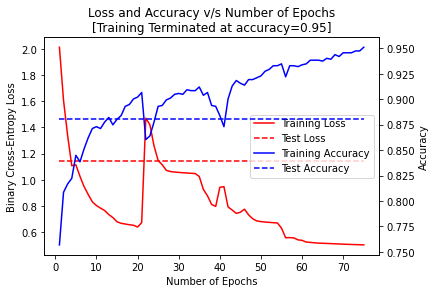

In [14]:
# Now print the loss and accuracy over the training epochs

fig, ax = plt.subplots()
p1 = ax.plot(np.arange(1,final_epoch+2), history.history['loss'], color = 'red', label = 'Training Loss')
p2 = ax.plot(np.arange(1,final_epoch+2), [test_loss for _ in np.arange(1, final_epoch+2)], color = 'red', linestyle = 'dashed', label = 'Test Loss')
ax.set_title('Loss and Accuracy v/s Number of Epochs\n[Training Terminated at accuracy='+str(accthreshold)+']')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Binary Cross-Entropy Loss')
axd = ax.twinx()
p3 = axd.plot(np.arange(1, final_epoch+2), history.history['acc'], color = 'blue', label = 'Training Accuracy')
p4 = axd.plot(np.arange(1,final_epoch+2), [test_accuracy for _ in np.arange(1, final_epoch+2)], color = 'blue', linestyle = 'dashed', label = 'Test Accuracy')
p = p1+p2+p3+p4
labs = [l.get_label() for l in p]
ax.legend(p, labs, loc = 'center right')
axd.set_ylabel('Accuracy')

### Tuning Hyperparameters in Neural Network Training

In [13]:
# %load_ext tensorboard
%load_ext tensorboard

In [14]:
# For this we have to create a validation dataset as well

Xtrainval, Xtest, Ytrainval, Ytest = train_test_split(IBMDataNew, IBMDataNewLabel, test_size = 0.15, random_state = seed)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrainval, Ytrainval, test_size = 0.18, random_state = seed)

print(Xtrain.shape, Xval.shape, Xtest.shape, Ytrain.shape, Yval.shape, Ytest.shape)

(1024, 51) (225, 51) (221, 51) (1024,) (225,) (221,)


In [26]:
HP_units = hp.HParam('units', hp.Discrete([64, 128]))
HP_dropout = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_lr = hp.HParam('lr', hp.Discrete([0.0005, 0.001]))
HP_optimizer = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))
HP_activation = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid']))
METRIC_ACCURACY = 'accuracy'

hparams = [HP_units, HP_dropout, HP_lr, HP_optimizer, HP_activation]
metrics = [hp.Metric(METRIC_ACCURACY, display_name = 'Accuracy')]

log_dir = 'log/hparam_tuning_new/'
with tf.summary.FileWriter(log_dir):
    hp.hparams_config(hparams = [HP_units, HP_dropout, HP_lr, HP_optimizer, HP_activation], 
                     metrics = [hp.Metric(METRIC_ACCURACY, display_name = 'Accuracy')])
    
global INPUT_SHAPE
INPUT_SHAPE = Xtrain.shape[1]    

In [36]:
# def create_model(hparams):
    
#     # Define the model with some of the hyperparameters
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Dense(input_shape = (INPUT_SHAPE,), units = hparams[HP_units], activation = hparams[HP_activation]), 
#         tf.keras.layers.Dense(units = 1, activation = hparams[HP_activation])
#     ])
    
#     # Define the model compilation
#     optimizer = hparams[HP_optimizer]
#     learning_rate = hparams[HP_lr]
#     if optimizer == 'adam':
#         optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
#     elif optimizer == 'sgd':
#         optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
#     elif optimizer == 'rmsprop':
#         optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
#     else:
#         raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))        
#     model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#     # Fit the model
#     history = model.fit(Xtrain, Ytrain, callbacks = [tf.keras.callbacks.TensorBoard(log_dir), 
#                                                     hp.KerasCallback(log_dir, hparams)])
    
#     return history.history['val_accuracy'][-1]    


# def run(run_dir, hparams):
#     with tf.summary.FileWriter(run_dir):
#         hp.hparams(hparams)
#         accuracy = create_model(hparams)
#         accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
#         tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        
        
# session_num = 0
# for units in HP_units.domain.values:
#     for dropout_rate in (HP_dropout.domain.min_value, HP_dropout.domain.max_value):
#         for lr in HP_lr.domain.values:
#             for optimizer in HP_optimizer.domain.values:
#                 for activation in HP_activation.domain.values:
                    
#                     hparams = {HP_units:units, 
#                               HP_dropout:dropout_rate,
#                               HP_lr:lr,
#                               HP_optimizer:optimizer,
#                               HP_activation:activation}
#                     run_name = "run-%d" % session_num
#                     print('--- Starting Trial: %s' % run_name)
#                     print({h.name: hparams[h] for h in hparams})
#                     run('logs/hparam_tuning/' + run_name, hparams)
#                     session_num += 1        

In [33]:
def create_model(hparams):
    
    # Define the model with some of the hyperparameters
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_shape = (INPUT_SHAPE,), units = hparams[HP_units], activation = hparams[HP_activation]), 
        tf.keras.layers.Dense(units = 1, activation = hparams[HP_activation])
    ])
    
    # Define the model compilation
    optimizer = hparams[HP_optimizer]
    learning_rate = hparams[HP_lr]
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))        
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Fit the model
    history = model.fit(Xtrain, Ytrain, validation_data = (Xval, Yval), epochs = 100, verbose = 0)
    
    
    return history.history['val_acc'][-1]


def run(run_dir, hparams):
#     with tf.summary.FileWriter(run_dir):
    hp.hparams(hparams)
    accuracy = create_model(hparams)
    return accuracy
    #accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
    #tf.summary.scalar(METRIC_ACCURACY, accuracy)
        

session_num = 0
results_dict = pd.DataFrame({'units':[], 
                            'dropout':[],
                            'lr':[],
                            'optimizer':[],
                            'activation':[], 
                            'accuracy':[]})

for units in HP_units.domain.values:
    for dropout_rate in (HP_dropout.domain.min_value, HP_dropout.domain.max_value):
        for lr in HP_lr.domain.values:
            for optimizer in HP_optimizer.domain.values:
                for activation in HP_activation.domain.values:
                    
                    hparams = {HP_units:units, 
                              HP_dropout:dropout_rate,
                              HP_lr:lr,
                              HP_optimizer:optimizer,
                              HP_activation:activation}
                    run_name = "run-%d" % session_num
                    print('--- Starting Trial: %s' % run_name)
                    #print({h.name: hparams[h] for h in hparams})
                    results_dict = pd.concat([results_dict, 
                                              pd.DataFrame({'units':[units], 
                                                            'dropout':[dropout_rate], 
                                                            'lr':[lr], 
                                                            'optimizer':[optimizer], 
                                                            'activation':[activation], 
                                                            'accuracy':[run(log_dir + run_name, hparams)]})], 
                                             ignore_index = True)
                    session_num += 1                

--- Starting Trial: run-0
--- Starting Trial: run-1
--- Starting Trial: run-2
--- Starting Trial: run-3
--- Starting Trial: run-4
--- Starting Trial: run-5
--- Starting Trial: run-6
--- Starting Trial: run-7
--- Starting Trial: run-8
--- Starting Trial: run-9
--- Starting Trial: run-10
--- Starting Trial: run-11
--- Starting Trial: run-12
--- Starting Trial: run-13
--- Starting Trial: run-14
--- Starting Trial: run-15
--- Starting Trial: run-16
--- Starting Trial: run-17
--- Starting Trial: run-18
--- Starting Trial: run-19
--- Starting Trial: run-20
--- Starting Trial: run-21


Exception ignored in: Exception ignored in: <function BaseSession._Callable.__del__ at 0x000000925B98F1F8>
Traceback (most recent call last):
  File "C:\Users\Public\anaconda3\envs\tfenv\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
KeyboardInterruptException ignored in: <function BaseSession._Callable.__del__ at 0x000000925B98F1F8>
Traceback (most recent call last):
  File "C:\Users\Public\anaconda3\envs\tfenv\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
KeyboardInterrupt


--- Starting Trial: run-22
--- Starting Trial: run-23
--- Starting Trial: run-24
--- Starting Trial: run-25
--- Starting Trial: run-26
--- Starting Trial: run-27
--- Starting Trial: run-28
--- Starting Trial: run-29
--- Starting Trial: run-30
--- Starting Trial: run-31


In [24]:
# %tensorboard --logdir logs/hparam_tuning/

In [38]:
results_dict.sort_values(by = ['accuracy'], ascending = False, inplace = True, ignore_index = True)
results_dict

,units,dropout,lr,optimizer,activation,accuracy
0,64.0,0.2,0.0005,adam,sigmoid,0.902222
1,64.0,0.1,0.0010,rmsprop,sigmoid,0.902222
2,64.0,0.1,0.0005,adam,sigmoid,0.902222
3,128.0,0.1,0.0010,adam,sigmoid,0.902222
4,64.0,0.2,0.0010,adam,sigmoid,0.902222
5,128.0,0.1,0.0005,adam,sigmoid,0.902222
6,128.0,0.1,0.0010,rmsprop,sigmoid,0.897778
7,64.0,0.2,0.0005,rmsprop,sigmoid,0.897778
8,64.0,0.2,0.0010,rmsprop,sigmoid,0.897778
9,128.0,0.2,0.0010,rmsprop,sigmoid,0.897778
